In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR as sk_SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import cuml
import cupy as cp
from cuml.linear_model import LinearRegression
from cuml.linear_model import ElasticNet
from cuml.svm import SVR as cu_SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')


In [3]:
sales_train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
# Check Missing Data
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
#reformat the data
sales_train = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price':'mean','item_cnt_day':'sum'}).reset_index()
# disp The Data
sales_train.head(5)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,128.5,2.0


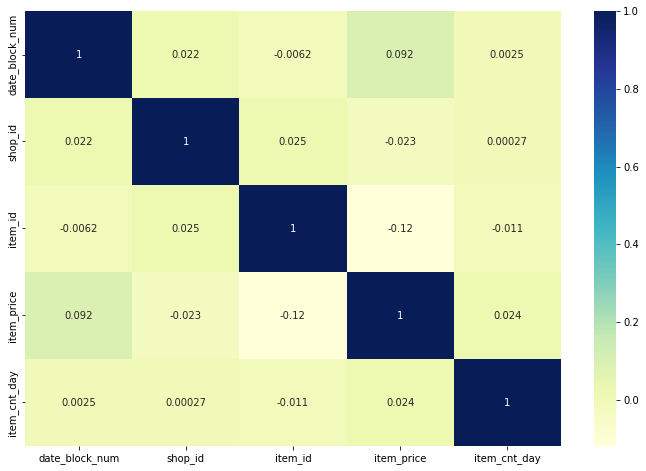

In [8]:
plt.figure(figsize=(12,8))
dataplot = sns.heatmap(sales_train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [9]:
# Prepare The Test Data as Training Data
test['date_block_num'] = 34
test_data=test[['date_block_num','shop_id','item_id']]
test_data.head()

,date_block_num,shop_id,item_id
0,34,5,5037
1,34,5,5320
2,34,5,5233
3,34,5,5232
4,34,5,5268


In [10]:
item_price=dict(sales_train.groupby('item_id')['item_price'].last().reset_index().values)
test_data['item_price']=test_data.item_id.map(item_price)
print(test_data)
print(sales_train)

        date_block_num  shop_id  item_id  item_price
0                   34        5     5037      1499.0
1                   34        5     5320         NaN
2                   34        5     5233      1199.0
3                   34        5     5232      1199.0
4                   34        5     5268         NaN
...                ...      ...      ...         ...
214195              34       45    18454        99.0
214196              34       45    16188      1359.0
214197              34       45    15757       229.0
214198              34       45    19648        79.2
214199              34       45      969       198.0

[214200 rows x 4 columns]
         date_block_num  shop_id  item_id  item_price  item_cnt_day
0                     0        0       32       221.0           6.0
1                     0        0       33       347.0           3.0
2                     0        0       35       247.0           1.0
3                     0        0       43       221.0           1

In [11]:
# Fill Missing Features in Testing Data
test_data['item_price'] = test_data['item_price'].fillna(test_data['item_price'].median())
print(test_data)

        date_block_num  shop_id  item_id  item_price
0                   34        5     5037      1499.0
1                   34        5     5320       449.0
2                   34        5     5233      1199.0
3                   34        5     5232      1199.0
4                   34        5     5268       449.0
...                ...      ...      ...         ...
214195              34       45    18454        99.0
214196              34       45    16188      1359.0
214197              34       45    15757       229.0
214198              34       45    19648        79.2
214199              34       45      969       198.0

[214200 rows x 4 columns]


In [12]:
# There Are Too Many Records, i'll Take Sample
# i'll take a small Sample Because SVM Takes Very loooooooooooooooooooooooooooooong Time
sales_train = sales_train.sample(frac = .3,random_state=98) 
print(sales_train)

         date_block_num  shop_id  item_id  item_price  item_cnt_day
853038               15       25    17787    199.0000           1.0
889793               16       15    12771    549.0000           1.0
90940                 1       27     2108    199.0000           1.0
75122                 1       13     4013    161.0000           1.0
172752                2       50    14851    399.0000           8.0
...                 ...      ...      ...         ...           ...
1224666              23       31     7876    649.0000           3.0
1056102              19       50     6472    349.3125          11.0
1067758              20        3     5601    479.2000           1.0
1516814              31        6     3243    599.0000           2.0
62726                 0       59    11305    499.0000           1.0

[482737 rows x 5 columns]


In [13]:
# to Save All accuracies
performance = pd.DataFrame(columns=['Model Name','RMSE','Time'],)

# Using SkLearn

In [14]:
sc = StandardScaler()

In [15]:
X = np.array(sales_train.drop(['item_cnt_day'], axis =1 ))
Y = np.array(sales_train.iloc[:,4])
X = sc.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 25 )

## **Linear Reg**

In [16]:
%%time
start_time = time.time()
# Define The Model
regressor = LinearRegression()
# Fitting The Model
regressor.fit(X_train,Y_train)
#Prediction The Test Set Results
y_pred = regressor.predict(X_test)
# Calculate The RMSE
rmse = mean_squared_error(Y_test,y_pred,squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 1.96 s, sys: 947 ms, total: 2.9 s
Wall time: 6.45 s


9.643344201319843

In [17]:
newResult = {'Model Name':'linear_sklearn','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.44871


## **SVR**

***it's taking too much time, i'll use it with cuml***

> %%time
> #Define The Model
> svr = sk_SVR(kernel='linear',cache_size=5000,C=10,verbose=6)
> #Fitting The Data
> svr.fit(X_train,Y_train)
> #Test on Testing Data
> svr_pred = svr.predict(X_test)
> #Calculate The Error
> rmse = mean_squared_error(Y_test,svr_pred,squared=False)
> accuracies['svr_sklearn'] = rmse
> rmse

## **Decision Tree**

In [18]:
%%time
start_time = time.time()
#Define The Model
dt_regressor = DecisionTreeRegressor()
#Fitting The Data
dt_regressor.fit(X_train,Y_train)
#Test on Testing Data
dt_pred = dt_regressor.predict(X_test)
#Calculate The Error
rmse = mean_squared_error(Y_test,dt_pred,squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 1.87 s, sys: 7.05 ms, total: 1.88 s
Wall time: 1.88 s


10.318715607302947

In [19]:
newResult = {'Model Name':'dt_regressor','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305


# **Ensemble Models**

## **Random Forest**

In [20]:
%%time
start_time = time.time()
RFR = RandomForestRegressor()
RFR.fit(X_train,Y_train)
#Test on Testing Data
RFR_pred = RFR.predict(X_test)
#Calculate The Error
rmse = mean_squared_error(Y_test,RFR_pred,squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 2min 1s, sys: 767 ms, total: 2min 1s
Wall time: 2min 1s


7.19716232812137

In [21]:
newResult = {'Model Name':'RandomForestRegressor','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702


## **LightGBM** 

In [22]:
%%time
start_time = time.time()
lgbm = LGBMRegressor(n_estimators=100)
lgbm.fit(X_train,Y_train)
#Test on Testing Data
lgbm_pred = lgbm.predict(X_test)
#Calculate The Error
rmse = mean_squared_error(Y_test,lgbm_pred,squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 2.56 s, sys: 27 ms, total: 2.59 s
Wall time: 1.33 s


7.587387407441649

In [23]:
newResult = {'Model Name':'lgbm','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702
3,lgbm,7.587387,1.325683


## **XGBoost**

In [24]:
%%time
start_time = time.time()
XGB = XGBRegressor(n_estimators=100, learning_rate=0.03, n_jobs=8) 
XGB.fit(X_train, Y_train) # Your code here
y_pred = XGB.predict(X_test)
rmse = mean_squared_error(Y_test,y_pred,squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 27 s, sys: 305 ms, total: 27.4 s
Wall time: 14.9 s


7.8091457031538525

In [25]:
newResult = {'Model Name':'XGB','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702
3,lgbm,7.587387,1.325683
4,XGB,7.809146,14.890279


# **Using CUML**
Sklearn is Slow Bcoz it Works on CPU So, I'll Try To Use CUML which Runs On GPU

In [26]:
X_train, X_test, Y_train, Y_test  = cp.array(X_train),cp.array(X_test),cp.array(Y_train),cp.array(Y_test)

## **Linear Reg**

In [27]:
%%time
start_time = time.time()
lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")

reg = lr.fit(X_train,Y_train)
linear_cuml_preds = lr.predict(X_test)
rmse = mean_squared_error(np.array(Y_test.get()),np.array(linear_cuml_preds.get()),squared=False)
total_time= time.time() - start_time
rmse

CPU times: user 12.8 ms, sys: 3.02 ms, total: 15.8 ms
Wall time: 14.9 ms


9.643344201319843

In [28]:
newResult = {'Model Name':'linear_cuml','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702
3,lgbm,7.587387,1.325683
4,XGB,7.809146,14.890279
5,linear_cuml,9.643344,0.014852


## **ElasticNet**

In [29]:
%%time
start_time = time.time()
enet = ElasticNet(alpha = 0.1, l1_ratio=0.5)
reg = enet.fit(X_train,Y_train)
enet_cuml_preds = enet.predict(X_test)
rmse = mean_squared_error(np.array(Y_test.get()),np.array(enet_cuml_preds.get()),squared=False)
total_time= time.time() - start_time
rmse


CPU times: user 8.47 ms, sys: 1.01 ms, total: 9.49 ms
Wall time: 14 ms


9.643541473765914

In [30]:
newResult = {'Model Name':'elasticNet_cuml','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702
3,lgbm,7.587387,1.325683
4,XGB,7.809146,14.890279
5,linear_cuml,9.643344,0.014852
6,elasticNet_cuml,9.643541,0.013968


## **SVR**

In [31]:
%%time
start_time = time.time()
reg = cu_SVR(kernel='linear', gamma='scale', epsilon=0.1,verbose= 6)
reg = reg.fit(X_train,Y_train)
svr_cuml_preds = reg.predict(X_test)
rmse = mean_squared_error(np.array(Y_test.get()),np.array(svr_cuml_preds.get()),squared=False)
total_time= time.time() - start_time
rmse

[D] [20:22:37.020821] ../src/svm/workingset.cuh:109 Creating working set with 1024 elements
[D] [20:22:37.027013] ../src_prims/cache/cache.cuh:162 Creating cache with size=1024.000000 MiB, to store 352 vectors, in 11 sets with associativity=32
[D] [20:22:37.027337] ../src/svm/kernelcache.cuh:123 Allocating kernel tile, size: 2828 MiB
[D] [20:22:37.030976] ../src/svm/kernelcache.cuh:128 Allocating x_ws, size: 4 KiB
[D] [20:22:39.595861] ../src/svm/smosolver.cuh:433 Solver is not converging monotonically. This might be caused by insufficient normalization of the feature columns. In that case MinMaxScaler((0,1)) could help. Alternatively, for nonlinear kernels, you can try to increase the gamma parameter. To limit execution time, you can also adjust the number of iterations using the max_iter parameter.
[D] [20:22:49.585773] ../src/svm/smosolver.cuh:181 SMO iteration 500, diff 10.603252
[D] [20:23:02.597733] ../src/svm/smosolver.cuh:181 SMO iteration 1000, diff 10.183497
[D] [20:23:16.024

9.717895686680157

In [32]:
newResult = {'Model Name':'SVR_cuml','RMSE':rmse,'Time':total_time}
performance = performance.append(newResult,ignore_index=True)
performance

,Model Name,RMSE,Time
0,linear_sklearn,9.643344,6.448710
1,dt_regressor,10.318716,1.876305
2,RandomForestRegressor,7.197162,121.891702
3,lgbm,7.587387,1.325683
4,XGB,7.809146,14.890279
5,linear_cuml,9.643344,0.014852
6,elasticNet_cuml,9.643541,0.013968
7,SVR_cuml,9.717896,74.140144


# **Visualize Results**

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'linear_sklearn'),
  Text(1, 0, 'dt_regressor'),
  Text(2, 0, 'RandomForestRegressor'),
  Text(3, 0, 'lgbm'),
  Text(4, 0, 'XGB'),
  Text(5, 0, 'linear_cuml'),
  Text(6, 0, 'elasticNet_cuml'),
  Text(7, 0, 'SVR_cuml')])

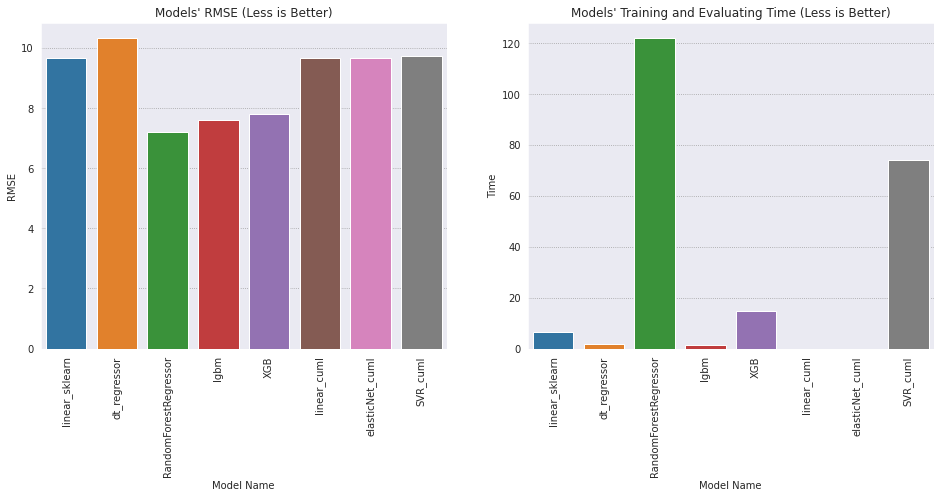

In [57]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=[16,6])

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.title("Models' RMSE (Less is Better)")
sns.barplot(x='Model Name',y='RMSE',data=performance,)
plt.xticks(rotation="90")

plt.subplot(1, 2, 2) # row 1, col 2 index 2
plt.title("Models' Training and Evaluating Time (Less is Better)")
sns.barplot(x='Model Name',y='Time',data=performance,)
plt.xticks(rotation="90")
